### x lines of Python

# Find and analyse global seismic data

This notebook goes with [the blog post](https://agilescientific.com/blog/2017/9/8/x-lines-of-python-global-seismic-data) of 8 September 2017. We'll look at 3 non-earthquakes:

1. A landslide and tsunami in Greenland, June 2017.
1. A nuclear weapon test in North Korea, September 2017.
1. A hurricane in the west Atlantic, September 2017.

Plus one earthquake — the estimated M8.2 off Mexico this morning, 8 September 2017.


## Landslide in Greenland

There was [a landslide in Greenland](http://temblor.net/earthquake-insights/greenland-earthquake-was-a-phantom-the-landslide-and-tsunami-were-real-4468/) in June. It triggered a fatal tsunami ([video](https://www.youtube.com/watch?v=LzSUDBbSsPI)). When I saw [Jascha Polet's tweet](https://twitter.com/CPPGeophysics/status/876502352710086656) about it, I was curious. [Ari Hartikainen's later tweet](https://twitter.com/a_hartikainen/status/878006334809034752) really made me want to look at the data.

Now let's get started!

First some preliminaries to make sure we get inline plots, and to turn off some matplotlib 2.0 warnings about a call ObsPy is making in its plotting functions somewhere.

In [3]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
from obspy.clients.fdsn import Client
client = Client("GFZ")

I'm just following the [instructions in the ObsPy documentation](https://docs.obspy.org/packages/obspy.clients.fdsn.html).

The event was at about 2340 UTC, but I'm going to grab a 2 hours' worth of data, starting well before the landslide event. You'll see why in a minute.

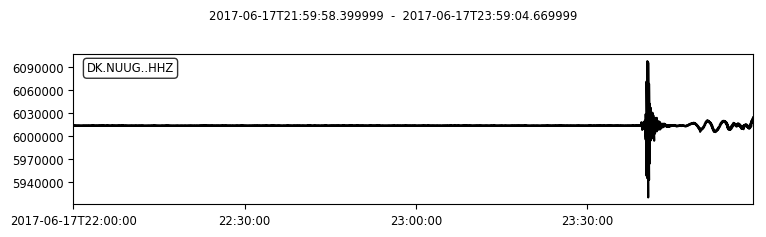

In [5]:
from obspy import UTCDateTime
t = UTCDateTime("2017-06-17_22:00:00")
st = client.get_waveforms("DK", "NUUG", "*", "HHZ", t, t + 2*60*60)
st.plot()  

Notice the landslide event, followed by the periodic signal of the tsunami.

What's **HHZ**? Seismic stations have lots of instruments and make their waveforms availables as various different channels, depending on the station. For example:
    
- `LHZ`: long period ~1 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- `BHZ`: broadband 10–80 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- `HHZ`: broadband 80–250 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- Some stations have loads of others, see Appendix A in [the SEED Manual](http://www.fdsn.org/seed_manual/SEEDManual_V2.4.pdf).

## Where is the station?

ObsPY is pretty cool. It can draw a map showing us where stations and events are.

Note that to do this you need `basemap` and `cartopy`:

    conda install basemap
    conda install cartopy

In [6]:
import matplotlib.pyplot as plt

inventory = client.get_stations(network="DK", station="NUUG")
inventory.plot(projection='local')  # Can be global or ortho or local (at low res by default)
plt.show()

ImportError: Neither Basemap nor Cartopy could be imported.

In [7]:
inventory

Inventory created at 2018-01-18T20:24:50.762762Z
	Sending institution: SeisComP3 (GFZ)
	Contains:
		Networks (1):
			DK
		Stations (1):
			DK.NUUG (Nuugaatsiq, Greenland)
		Channels (0):


## Get the data from the stream

The ObsPy stream object contains all our data:

In [8]:
st

1 Trace(s) in Stream:
DK.NUUG..HHZ | 2017-06-17T21:59:58.399999Z - 2017-06-17T23:59:04.669999Z | 100.0 Hz, 714628 samples

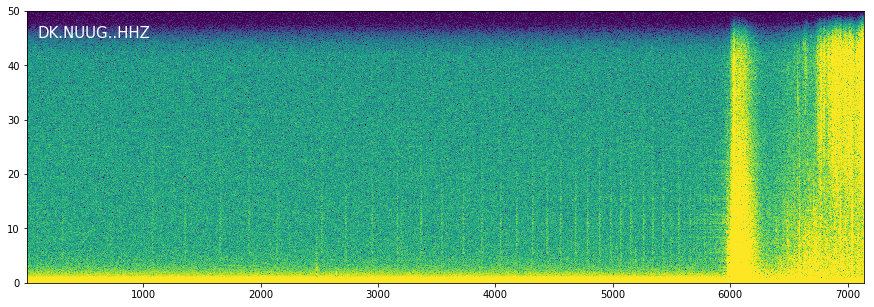

In [9]:
z = st.traces[0].data
NFFT = 2048
Fs = st.traces[0].meta.sampling_rate  # Sample rate in Hz
label = "{network}.{station}.{location}.{channel}".format(**st.traces[0].meta)

plt.figure(figsize=(15, 5))
Pxx, freqs, bins, im = plt.specgram(z, NFFT=NFFT, Fs=Fs, noverlap=int(0.9*NFFT), cmap='viridis', vmin=-30, vmax=30)
plt.text(100, 45, label, size=15, color='white')
plt.show()

Notice the increasingly frequent signals preceeding the landslide event. You can hear them in [the sonification of this event](http://ds.iris.edu/files/products/seissound/data/Movie/10228170_DK_NUUG_HHZ_2017_06_17_233912_vco_720.mp4) — and listen for the tsunami after the crash. 


<hr>

## Nuclear test in North Korea

Let's move around the world to a different kind of event. North Korea [made another nuclear test this morning](https://www.theguardian.com/world/2017/sep/03/north-korean-nuclear-test-confirmed-in-major-escalation-by-kim-jong-un) just after 0330 UTC. Inspired by [Steven Gibbons's tweets](https://twitter.com/stevenjgibbons/status/904238963908648960) the morning of the test, I wanted to download the data for myself.

From his tweets, we want station [**MDJ**](https://www.fdsn.org/station_book/CD/MDJ/mdj.html) in eastern China, which is in network code [**IC**](http://www.fdsn.org/networks/detail/IC/).

In [10]:
client = Client("IRIS")

inventory = client.get_stations(network="IC", station="MDJ")
inventory.plot()
plt.show()

ImportError: Neither Basemap nor Cartopy could be imported.

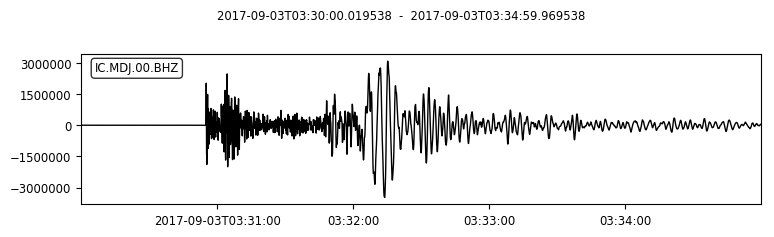

In [11]:
t = UTCDateTime("2017-09-03_03:30:00")
st = client.get_waveforms("IC", "MDJ", "00", "BHZ", t, t + 5*60)
st.plot()  

Again, following Steve's tweets, let's compare to the test last year, on 9 September 2016 at 0030 UTC:

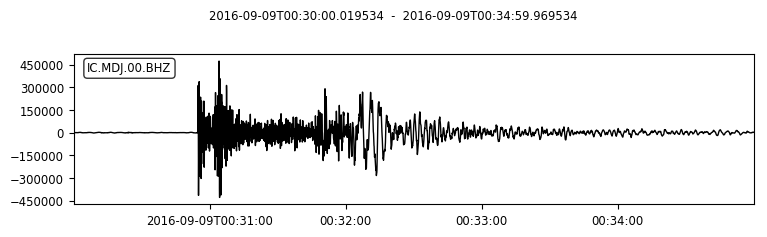

In [12]:
t = UTCDateTime("2016-09-09_00:30:00")
st1 = client.get_waveforms("IC", "MDJ", "00", "BHZ", t, t + 5*60)
st1.plot()  

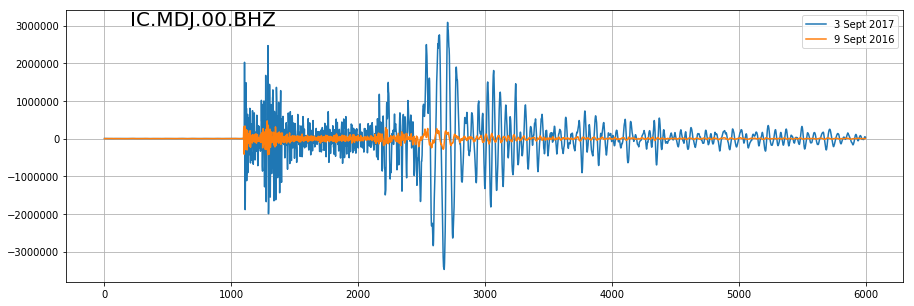

In [13]:
label = "{network}.{station}.{location}.{channel}".format(**st.traces[0].meta)

plt.figure(figsize=(15,5))
plt.plot(st.traces[0], label="3 Sept 2017")
plt.plot(st1.traces[0], label="9 Sept 2016")
plt.text(200, 3e6, label, size=20)
plt.legend()
plt.grid()
plt.show()

I'll leave making the spectrogram for this event as an exercise for the reader. Hint: use the `HHZ` channel for better time resolution, and get a longer signal for better frequency resolution. See if you can see evidence for other events (chamber collapse? [Landslides?](https://twitter.com/stevenjgibbons/status/905143760270618625) about 10 minutes after the detonation.

<hr>

## Hurricane Irma

This time we'll get inspired by [@seismo_steve's tweets](https://twitter.com/seismo_steve/status/905315486736449537) about Irma. He used stations on Barduda, Guadalupe, and St Maarten; we'll find the one in Barbuda, in the USGS Caribbean [`CU`](http://www.fdsn.org/networks/detail/CU/) network.

In [14]:
client = Client("IRIS")

inventory = client.get_stations(network="CU", station="ANWB")
inventory.plot(projection='global')  # Can be global or ortho or local (at low res by default_)
plt.show()

ImportError: Neither Basemap nor Cartopy could be imported.

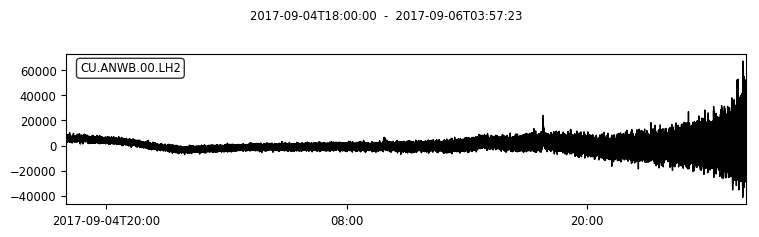

In [15]:
t0 = UTCDateTime("2017-09-04_18:00:00")
t1 = t0 + 36*60*60

st = client.get_waveforms("CU", "ANWB", "00", "LH2", t0, t1)
st.plot()  

In [16]:
st.traces[0].meta.sampling_rate

1.0

The **LH2** channel is long period, with a 1 Hz sample rate. Let's clean it up a bit by eliminating the low frequency wiggle.

In [17]:
st.filter('highpass', freq=0.1)

1 Trace(s) in Stream:
CU.ANWB.00.LH2 | 2017-09-04T18:00:00.000000Z - 2017-09-06T03:57:23.000000Z | 1.0 Hz, 122244 samples

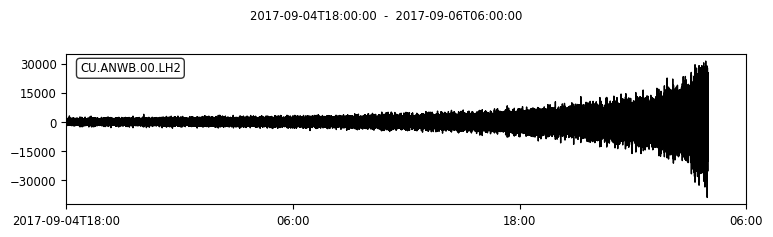

In [18]:
st.plot(endtime=t1)

This compares well with [Steve's tweet](https://twitter.com/seismo_steve/status/905320899733282816). 

You can clearly see the increase in noise as the storm approaches, and the failure of communications (or some other critical part of the system) and loss of signal.

Let's try listening to it!

In [19]:
from scipy.io import wavfile
import numpy as np

N = 24000 # Samples per second, a speed up of 24,000 x

wavfile.write('../data/irma.wav', N, st.traces[0].data.astype(np.int16))

In [20]:
import IPython
IPython.display.Audio("../data/irma.wav")

OK, that's pretty cool.

<hr> 

## Mexico M8.2 event

OK then, let's look at an actual earthquake. [This morning](http://www.bbc.com/news/world-latin-america-41197831) there was a very large earthquake off Mexico, killing at least 15 people.

In [21]:
client = Client("IRIS")

inventory = client.get_stations(network="MX")
inventory.plot(projection='local')  # Can be global or ortho or local (at low res by default_)
plt.show()

ImportError: Neither Basemap nor Cartopy could be imported.

According to the BBC article, the quake struck at 04:50 UTC.

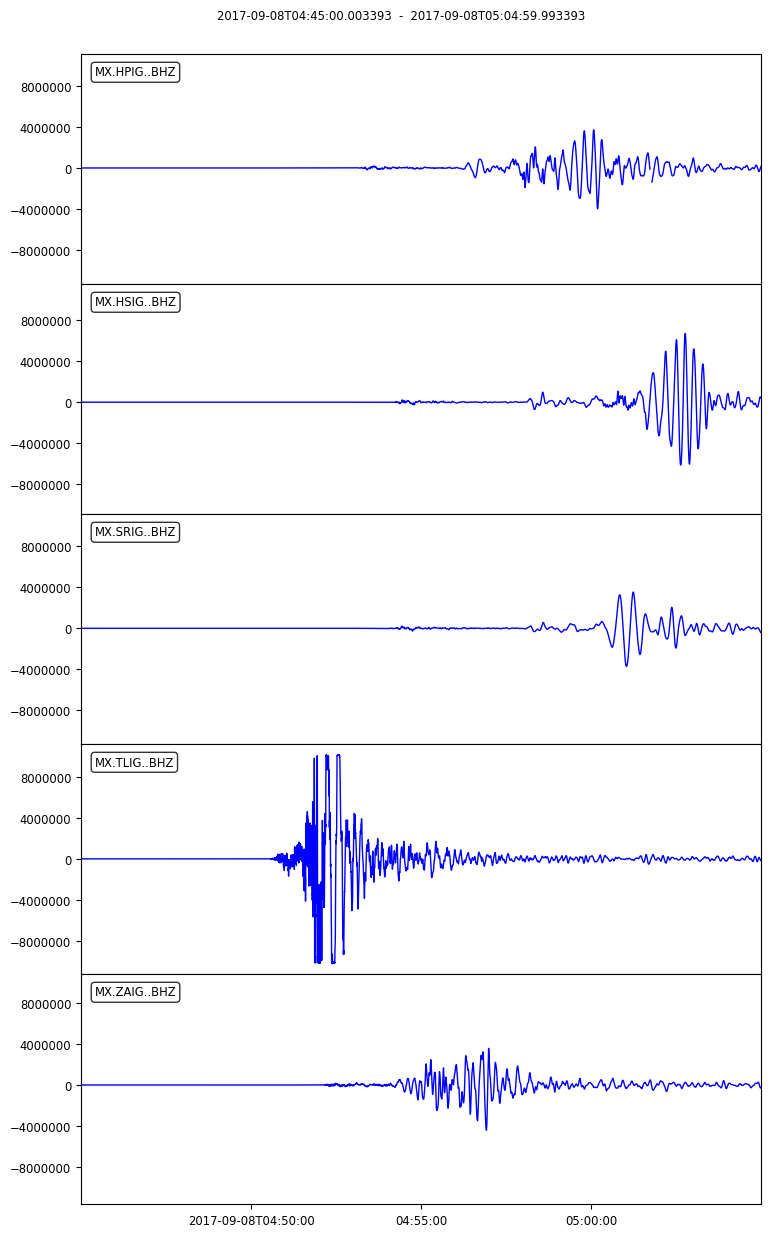

In [22]:
t = UTCDateTime("2017-09-08_04:45:00")

st = client.get_waveforms("MX", "*", "*", "BHZ", t, t + 20*60)
st.plot(color='blue')  

<hr>

**&copy; 2017 [agilescientific.com](https://www.agilescientific.com/) and licensed [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)**